In [1]:
# -*- coding: Paper1 -*-
"""
This code belongs to the paper:
-- An Iterative Gradient Descent-Based Reinforcement Learning Policy 
   for Active Control of Structural Vibrations, Computers & Structures.
-- Jagajyoti Panda, Mudit Chopra, Vasant Matsagar, Souvik Chakraborty, IIT Delhi.
   
This code is to present RL-based control algorithm in proportional (P) to state feedback.
-- Case study I: Quarter car model 
   State-space representation, Policy parameter update, Efficacy of trained RL-controller
"""

from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import os
from numpy import abs as Abs
from numpy import sign as sign
from numpy import sqrt,pi,array
from scipy import signal
 
 
import matplotlib
import matplotlib.pyplot as plt

from control.matlab import *  # MATLAB-like functions
import control as ct
 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [75]:
# Quarter car model
M = 600  # Body mass (in Kg)
m = 75  # Mass of tyre (in Kg)
Ks = 30  # Spring constant
Kt = 300  # Spring constant of wheel
Cs = 60  # Damping coefficient
n = 2  # DOF
r = 1  # No of Actuator

# MR Damper
V = 20
K1 = 542.18
K2 = 550.16
C1 = 999.4
C2 = 3387.5
alpha  = 3846.2 
beta = 126.84
gamma = 303.83 
A1 = 96.067
N = 3

# State space representation (states - y1, y2, dot(y1), dot(y2)) 
# Continous time (without damping)
A =np.array([[0 ,0 ,1 ,0 ],
              [0 ,0 ,0 ,1 ],
              [-Ks/M, Ks/M, 0, 0],
              [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
# print(A)
Az =np.array([[0 ,0 ,1 ,0 ],
              [0 ,0 ,0 ,1 ],
              [-Ks/M, Ks/M, -Cs/M, Cs/M],
              [Ks/m, -1*(Ks+Kt)/m, Cs/m, -Cs/m]])
# Input matrix (Control force and Earthquake input)
B  = np.array([[0,0,1/M,-1/m]]).T
print(B)
# Influence vector (Earthquake input)
E = np.array([[0,0,0,Kt/m]]).T 
print(E)
# Output matrix (Disp + Accel)
Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
# Output matrix (with damping)
Cdz = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, -Cs/M, Cs/M], [Ks/m, -1*(Ks+Kt)/m, Cs/m, -Cs/m]])
print(Cd)
Dd = np.array([[0, 1/M, -1/m]]).T
print(Dd)
Ed = np.array([[0, 0, 0]]).T
print(Ed)
# Cd = np.array([[1, 0, 0, 0]])
# Dd = np.array([[0]]).transpose()  
# Ed = np.array([[0]]).transpose()
# del M, m, Ks, Cs, Kt

[[ 0.        ]
 [ 0.        ]
 [ 0.00166667]
 [-0.01333333]]
[[0.]
 [0.]
 [0.]
 [4.]]
[[ 1.    1.    0.    0.  ]
 [-0.05  0.05  0.    0.  ]
 [ 0.4  -4.4   0.    0.  ]]
[[ 0.        ]
 [ 0.00166667]
 [-0.01333333]]
[[0]
 [0]
 [0]]


In [76]:
# Eigen value analysis
from numpy.linalg import eig
W,V=eig(A)  # Eigen Analysis
omega=sqrt(W)  # Frequency rad/sec
oma=array(omega)  
fn=oma/(2*pi)  # Frequency Hz

(array([ 4.00010002,  4.00014568,  4.0002122 ,  4.0003091 ,  4.0004503 ,
         4.00065611,  4.00095618,  4.00139396,  4.00203319,  4.00296781,
         4.00433724,  4.00635085,  4.00932992,  4.01378841,  4.02061632,
         4.03150197,  4.04714914,  4.05786722,  4.07955465,  4.11677273,
         4.17305174,  4.25757397,  4.3859557 ,  4.58485589,  4.90246468,
         5.43330759,  6.38150879,  8.1971794 , 10.89091853,  8.59993922,
         4.60059241,  2.65809358,  1.68768775,  1.14525764,  0.81563728,
         0.60272336,  0.45842607,  0.35661626,  0.28225786,  0.2263294 ,
         0.18323014,  0.14936978,  0.12236998,  0.10060072,  0.08290617,
         0.06843998,  0.05656449,  0.04678762,  0.03872234,  0.03205973]),
 array([-3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
        -3.14159265, -3.14159265, -3.14159266, -3.14159266, -3.14159268,
        -3.14159278, -3.14159316, -3.14159479, -3.14160241, -3.14164263,
        -3.14189853, -3.14349389, -3.14531422, -3

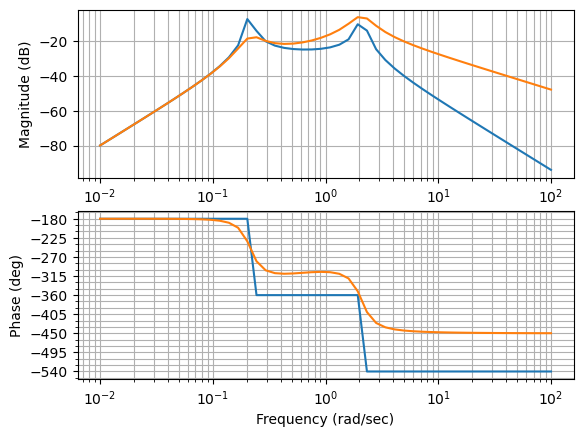

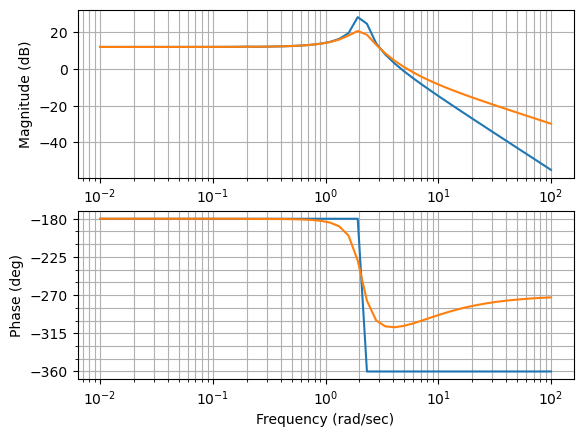

In [82]:
# Bode plot for the system (uncontrolled)
Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
plt.figure()
bode(ss(A, E, Cd[1, :], Ed[1]), logspace(-2, 2), plot=True)
bode(ss(Az, E, Cdz[1, :], Ed[1]), logspace(-2, 2), plot=True)
plt.figure()
bode(ss(A, E, Cd[2, :], Ed[2]), logspace(-2, 2), plot=True)
bode(ss(Az, E, Cdz[2, :], Ed[2]), logspace(-2, 2), plot=True)

In [84]:
from numpy.linalg import matrix_rank
ko = matrix_rank(ctrb(A, B))
if ko == len(A):
  print("System is controllable")
else:
  print("System is uncontrollable")
del ko

System is controllable


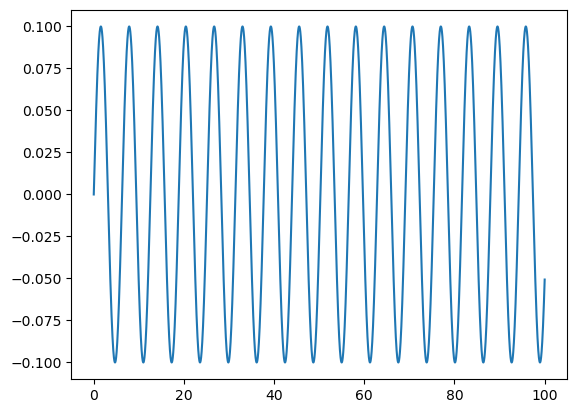

In [85]:
# Input Road Profile
T = 100
dt = 0.01
t = np.arange(0, T+dt, dt)
omega = 1
amplitude   = 0.1*np.sin(omega*t)
len(t)
plt.figure()
plt.plot(t, amplitude)

In [87]:
# Discrete time matrices
Ad = np.identity(2*n)
I = np.identity(2*n)
fact = 1
for x in range(1, 20):
    fact = fact * x
    Ad = Ad + ((A**x)*((dt**x)/fact))
    
Bd = (Ad-I)@np.linalg.inv(A)@B
Ed = (Ad-I)@np.linalg.inv(A)@E
Ed[1,0] = 0.0002 
print(Ad, Bd, Ed) 
del I, x

[[ 1.00000000e+00  0.00000000e+00  1.00501671e-02  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00501671e-02]
 [-4.99875021e-04  5.00125021e-04  1.00000000e+00  0.00000000e+00]
 [ 4.00801068e-03 -4.30460425e-02  0.00000000e+00  1.00000000e+00]] [[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.66625007e-05]
 [-1.33600356e-04]] [[ 0.00000000e+00]
 [ 2.00000000e-04]
 [-2.50000005e-07]
 [ 3.90380318e-02]]


In [89]:
# System State Space (PI controller)
FI = np.zeros((2*n+r,2*n+r))
FI[0:2*n,0:2*n] = Ad
FI[2*n,0:2*n] = Cd[0,:] @ Ad
FI[2*n,2*n] = np.identity(r)
print(FI)
gI = np.zeros((2*n+r,r))
gI[0:2*n,:] = Bd
gI[2*n,:] = Cd[0,:] @ Bd
print(gI)
BIrd = np.zeros((2*n+r,r))
BIrd[0:2*n,:] = Ed
BIrd[2*n,:] = Cd[0,:] @ Ed
print(BIrd)
# Output of PI controller
Cdi = np.zeros((n+r,2*n+r))
Cdi[0:n,0:2*n] = Cd[1:n+1,:]
Cdi[n,2*n] = np.identity(r)
print(Cdi)
Ddi = np.zeros((n+r,r))
Ddi[0:n,:] = Dd[1:n+1,:]
print(Ddi)
ko = matrix_rank(ctrb(FI, gI))
if ko == len(FI):
  print("System is controllable")
else:
  print("System is uncontrollable")
del ko

[[ 1.00000000e+00  0.00000000e+00  1.00501671e-02  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00501671e-02
   0.00000000e+00]
 [-4.99875021e-04  5.00125021e-04  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.00801068e-03 -4.30460425e-02  0.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00501671e-02  1.00501671e-02
   1.00000000e+00]]
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.66625007e-05]
 [-1.33600356e-04]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 2.00000000e-04]
 [-2.50000005e-07]
 [ 3.90380318e-02]
 [ 2.00000000e-04]]
[[-0.05  0.05  0.    0.    0.  ]
 [ 0.4  -4.4   0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.  ]]
[[ 0.00166667]
 [-0.01333333]
 [ 0.        ]]
System is controllable


[[  0.45506876  -1.01160002  36.40541381 -15.50802251]]
[[  0.49590136  -1.14546156  35.69758159 -11.83173935]]
[[ 0.49590136 -1.5503297  10.16911434 -1.10355288]]
(50, 3)
None
(10001, 5)
None


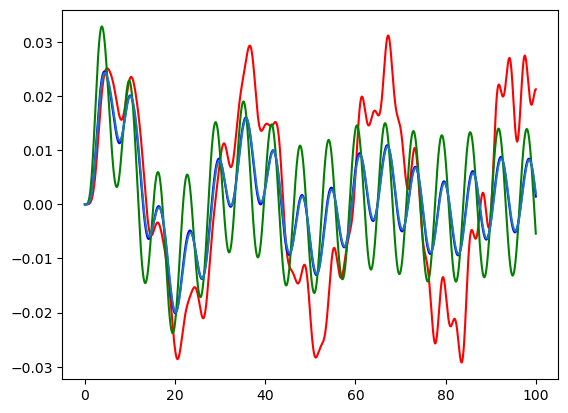

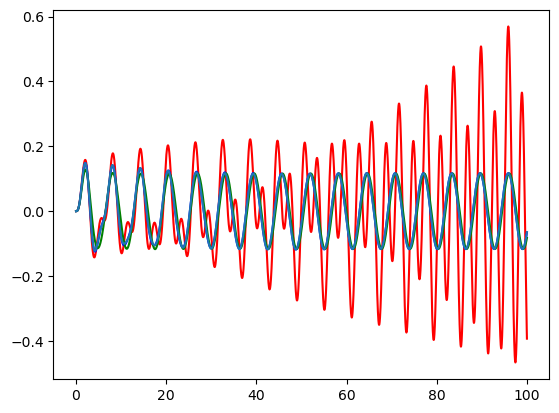

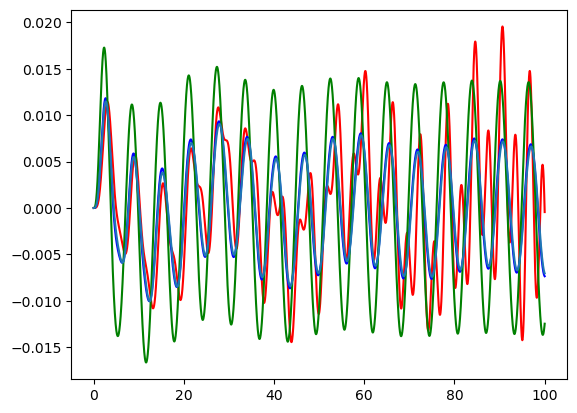

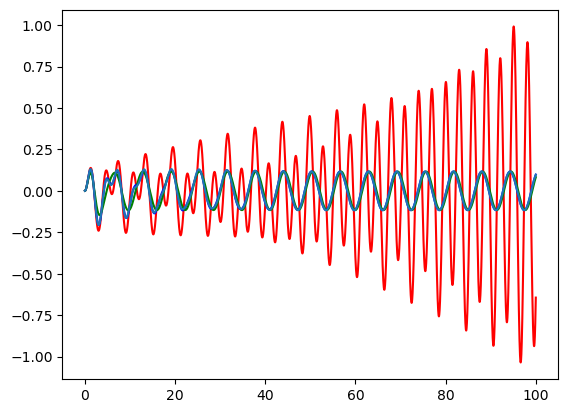

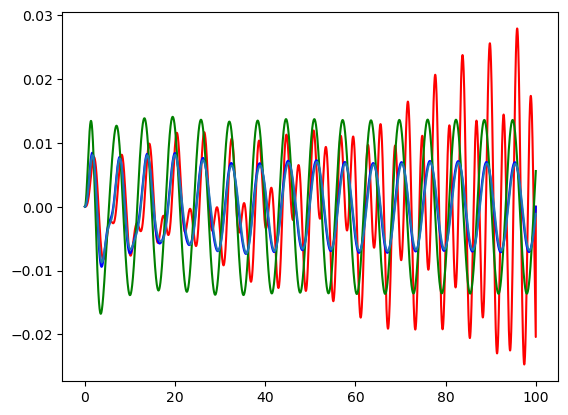

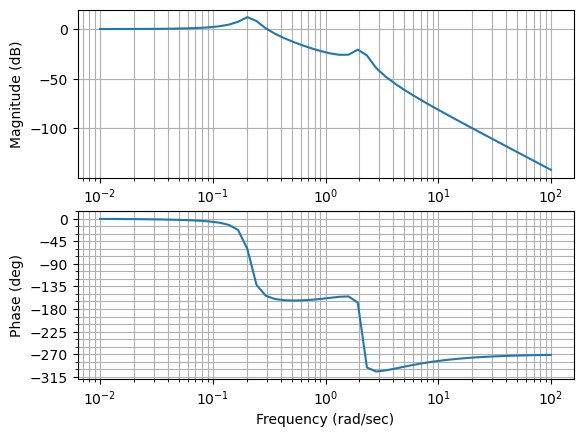

In [100]:
# System state space (continous time)
# sys_ud = ss(Ad, Bd, Cd, Dd, dt)
# print(sys_ud)
# LQR design (propertional)
# Start with a diagonal weighting
Qp = np.array([[Ks, -Ks, 0, 0],
            [-Ks, Ks+Kt, 0, 0],
            [0, 0, M, 0],
            [0, 0, 0, m]])
# print(Qp)
(i,j)=Bd.shape
Rp =  (10**(0))*np.identity(j)
Kp, Sp, ep = ct.dlqr(Ad, Bd, Qp, Rp)
print(Kp)  # Discrete time
Kp1, Sp1, ep1 = ct.lqr(A, B, Qp, Rp)
print(Kp1) # Continous time
Kpz, Spz, epz = ct.lqr(Az, B, Qp, Rp)
print(Kpz) # Continous time
del i,j,Sp,Sp1,ep,ep1, Spz, epz
# Time series analysis
xo = np.zeros((len(t),2*n))
xoz = np.zeros((len(t),2*n))
xp = np.zeros((len(t),2*n))
(i,j) = Cd.shape
yo = np.zeros((len(t),i))
yoz = np.zeros((len(t),i))
yp = np.zeros((len(t),i))
xp1 = np.zeros((len(t),2*n))
yp1 = np.zeros((len(t),i))
del i,j

for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    y = (Cd @ np.array([xo[tkk,:]]).T)
    yo[tkk,:] = y.T
    x = (Ad @ np.array([xo[tkk,:]]).T) + (Ed * amplitude[tkk])
    xo[tkk+1,:] = x.T
    y1 = (Cd @ np.array([xp[tkk,:]]).T) + (Dd @ ((-1*Kp) @ np.array([xp[tkk,:]]).T))
    yp[tkk,:] = y1.T
    x1 = (Ad @ np.array([xp[tkk,:]]).T) + (Bd @ ((-1*Kp) @ np.array([xp[tkk,:]]).T)) + (Ed * amplitude[tkk])
    xp[tkk+1,:] = x1.T
#     y2 = (Cd @ np.array([xp1[tkk,:]]).T) + (Dd @ ((-1*Kp1) @ np.array([xp1[tkk,:]]).T))
#     yp1[tkk,:] = y2.T
#     x2 = (Ad @ np.array([xp1[tkk,:]]).T) + (Bd @ ((-1*Kp1) @ np.array([xp1[tkk,:]]).T)) + (Ed * amplitude[tkk])
#     xp1[tkk+1,:] = x2.T
# Response with damping
sys_uc = signal.StateSpace(Az, E, Cdz, np.array([[0, 0, 0]]).T)
t_uc,yoz,xoz = signal.lsim(sys_uc,amplitude,t)
sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
t_c,yp1,xp1 = signal.lsim(sys_c,amplitude,t)

del x1,y1,x,y

for i in range(2*n):
    plt.figure()
    plt.plot(t, xo[:,i], 'r', t, xp[:,i], 'b', t, xoz[:,i], 'g', t, xp1[:,i])
del i    
for i in range(1,len(Cd)):
    plt.figure()
    plt.plot(t, yo[:,i], 'r', t, yp[:,i], 'b', t, yoz[:,i], 'g', t, yp1[:,i])
    
# Kp1 = np.load('ControllerP_QC.npy')
# print(Kp1)
mag_pc, phase_pc, om_pc = bode(ss(A-B@Kp1, E, np.array([1, 0, 0, 0])-Dd[0, :]@Kp1, np.array([0]).T), logspace(-2, 2), plot=True)
input = np.array([om_pc, mag_pc, phase_pc])
print(input.T.shape)
result=np.savetxt('Bode_pa.txt', input.T, delimiter=' ')
print(result)    
del input

input = np.array([t, xo[:,0], xoz[:,0], xp[:,0], xp1[:,0]])
print(input.T.shape)
result=np.savetxt('Res_damp.txt', input.T, delimiter=' ')
print(result) 


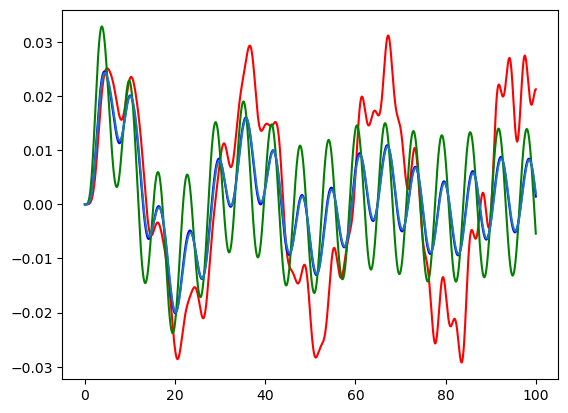

In [99]:
plt.figure()
plt.plot(t, xo[:,0], 'r', t, xp[:,0], 'b', t, xoz[:,0], 'g', t, xp1[:,0])

In [25]:
Fd = np.zeros((len(t),1))
Fc = np.zeros((len(t),1))
for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    Fd[tkk,:] = -Kp @ np.array([xp[tkk,:]]).T
    Fc[tkk,:] = -Kp1 @ np.array([xp1[tkk,:]]).T

In [246]:
# Initial controller gain (proportional)
print(Cdi,Ddi)
(i,j)=gI.shape
print(i,j)
Qp_i = np.array([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])
Kp, Sp, ep = ct.dlqr(Ad, Bd, Qp_i, Rp)
print(Kp)  # Discrete time
Kp1, Sp1, ep1 = ct.lqr(A, B, Qp_i, Rp)
print(Kp1) # Continous time

[[ 0.00648673  0.06591378  5.91978281 -5.92597087]]
[[ 0.01851217 -0.01030405  5.16462977 -1.05980545]]


In [26]:
# Modified B matrix 
# Propertional (continous)
Bj = B @ (-1*Kp1)
Al_t = A.T + Bj.T 
P = lyap(Al_t, -Qp)
print(Bj)
print(P)
# propertional (Discrete)
Bj_p = Bd @ (-1*Kp) 
Al_p = Ad.T + Bj_p.T 
P_p = dlyap(Al_p, -Qp)

[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.0008265   0.0019091  -0.05949597  0.01971957]
 [ 0.00661202 -0.01527282  0.47596775 -0.15775652]]
[[-5.60388195e+02  1.85873971e+02 -3.35420000e+02 -5.03729674e+00]
 [ 1.85873971e+02 -2.01982759e+03  4.26409397e+02 -3.23571106e+01]
 [-3.35420000e+02  4.26409397e+02 -1.14986282e+04 -1.02322121e+02]
 [-5.03729674e+00 -3.23571106e+01 -1.02322121e+02 -4.55606248e+02]]


In [248]:
# Dynamical equation (Rk4) (State)
def dydx(A1, B1, E1, U1, h1, x1):
#   print(x1,U1,h1)
  Bu  = U1*B1
#   print(Bu)
  fi = h1*E1
  k1 = dt*(A1@x1 + Bu@x1 + fi)
  k2 = dt*(A1@(x1 + 0.5*k1)+ Bu@(x1 + 0.5*k1) + fi)
  k3 = dt*(A1@(x1 + 0.5*k2)+ Bu@(x1 + 0.5*k2) + fi)
  k4 = dt*(A1@(x1 + k3)+ Bu@(x1 + k3) + fi)
  x2 = x1 + (k1 + 2*k2 + 2*k3 + k4)/6
  return x2

In [249]:
# Dynamical equation (Rk4) (Adjoint State)
def dydx1(A1, B1, E1, U1, h1, x1):
#   print(x1,U1,h1)
  Bu  = U1*B1
#   print(Bu)
  fi = h1*E1
  k1 = -dt*(A1@x1 + Bu@x1 + fi)
  k2 = -dt*(A1@(x1 + 0.5*k1)+ Bu@(x1 + 0.5*k1) + fi)
  k3 = -dt*(A1@(x1 + 0.5*k2)+ Bu@(x1 + 0.5*k2) + fi)
  k4 = -dt*(A1@(x1 + k3)+ Bu@(x1 + k3) + fi)
  x2 = x1 + (k1 + 2*k2 + 2*k3 + k4)/6
  return x2

In [250]:
# P-controller (Continous)
# Policy parameter update
Zmax = 501 # No of episodes
Qp = np.array([[Ks, -Ks, 0, 0],
            [-Ks, Ks+Kt, 0, 0],
            [0, 0, M, 0],
            [0, 0, 0, m]])
BK = np.zeros([2*n,2*n,Zmax])
BK[0:2*n,0:2*n,0] = Bj  # Initial Stiffness
dj_dk = np.zeros([2*n,2*n,Zmax])  # Gradient
alpha = 25  
x = np.zeros([len(t), 2*n, Zmax])  # State
p = np.zeros([len(t), 2*n, Zmax])  # Adjoint State
done = False
J_c = np.zeros([len(t), r, Zmax])  # Cost function
E_c = np.zeros([len(t), r, Zmax])  # Structure's energy
val_arr = np.zeros([len(t), r, Zmax]) # x.T*K*x
s = []  # number of tau_s

for id in range(0, Zmax-1):  
  BKo = BK[0:2*n,0:2*n,id] 
  print(BKo)
  for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    h = amplitude[tkk] 
    xn = np.array([x[tkk,:,id]]).T
#   print(xn)
    xn1 = dydx(A, BKo, E, 1, h, xn)
#     print(xn1)
    x[tkk+1,:,id] = xn1.T
    En1 = 0.5*((xn1.T @ Qp)@xn1)
    E_c[tkk+1,:,id] = En1
    Jn1 = J_c[tkk,:,id] + dt*(En1)
    J_c[tkk+1,:,id] = Jn1  # Cost functional
    del xn,xn1
  print(Jn1)  
  # Adjoint State  
  s.append([])
  for tkk in range(0,len(t)-1):
    i = len(t)-1-tkk
#     print(i)
    xn = np.array([x[i,:,id]]).T
    val = (xn.T @ BKo) @ xn
#     print(val)
    val_arr[i,:,id] = val
    if(val==0):
      pn = np.array([p[i,:,id]]).T
      s[id].append(i)
      d_ptau1 = (pn.T@BKo)@xn  # (1*n)@(n*n)@(n*1)
#       print(val)
      d_ptau = (d_ptau1[0,0]*((BKo + BKo.T)@xn))      #1*(1*1)*((n*n)@(n*1))  #############
#       d_ptau = (d_ptau1[0,0]*xn)      #1*(1*1)*((n*n)@(n*1))  #############
#       print(d_ptau)
      pnb1 = pn + d_ptau  # (n*1)
      p[i-1,:,id] = pnb1.T
    else:
      if(val[0]<0.000001 and val[0] >-0.000001):
        s[id].append(i)
      pn = np.array([p[i,:,id]]).T
      F = Qp@xn 
      pnb1 = dydx1(-A.T, -BKo.T, F, 1, 1, pn)  # Backward integration
      p[i-1,:,id] = pnb1.T
#     print(p[i-1,:,id])
    del xn, val, pn, pnb1, i
    
  # Evaluate dj/dk
  sum = dj_dk[0:2*n,0:2*n,id]
  print(len(s[id]))
  if(len(s[id])>0):
    for j in s[id]:
        xn = np.array([x[j,:,id]]).T
        pn = np.array([p[j,:,id]]).T
        sum1 = (pn.T@BKo)@xn  # (1*n)@(n*n)@(n*1)
        sum = sum +  ((-1)*(sum1[0,0]*(xn@xn.T)))  # 1*(1*1)*((n*1)@(1*n))  #############
    print(sum)
    dj_dk[0:2*n,0:2*n,id] = sum
  # Update K 
    BK[0:2*n,0:2*n,id+1] = BK[0:2*n,0:2*n,id]  - alpha*dj_dk[0:2*n,0:2*n,id]
  else:
    print(np.linalg.norm(dj_dk[0:2*n,0:2*n,id]))
#     break
      

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.08536204e-05  1.71734105e-05 -8.60771628e-03  1.76634242e-03]
 [ 2.46828963e-04 -1.37387284e-04  6.88617303e-02 -1.41307393e-02]]
[[167.42988255]]
256
[[ 3.21339787e-04 -1.05893441e-03 -3.24483039e-06  2.72893248e-06]
 [-1.05893441e-03  2.83253068e-02  5.52458962e-04 -2.53672883e-05]
 [-3.24483039e-06  5.52458962e-04  4.11181919e-05  1.07187943e-05]
 [ 2.72893248e-06 -2.53672883e-05  1.07187943e-05  2.65154585e-05]]
[[-8.03349467e-03  2.64733602e-02  8.11207598e-05 -6.82233120e-05]
 [ 2.64733602e-02 -7.08132670e-01 -1.38114741e-02  6.34182208e-04]
 [ 5.02671395e-05 -1.37943006e-02 -9.63567108e-03  1.49837256e-03]
 [ 1.78605651e-04  4.96794924e-04  6.85937604e-02 -1.47936258e-02]]
[[142.18500069]]
21
[[8.78891681e-15 6.52987699e-12 1.99697747e-14 1.05570264e-10]
 [6.52987699e-12 4.90063569e-09 1.49167701e-11 8.01013753e-08]
 [1.99697747e-14 1.4916770

In [16]:
# Figure (dj_dk, cost  functional)
z = np.arange(0, Zmax-1, 1)
n_djdk = np.zeros([Zmax-1, r])
J_Tl = np.zeros([Zmax-1, r])
del id
for id in range(0, Zmax-1):
    norm_djdk = np.linalg.norm(dj_dk[0:2*n,0:2*n,id])
    n_djdk[id,:] = norm_djdk
    J_T = J_c[len(t)-1,:,id]
    J_Tl[id, :] = J_T
plt.figure()
plt.plot(z, n_djdk/n_djdk[0,0])
plt.figure()
plt.plot(z, J_Tl/J_Tl[0,0])
input = np.array([J_Tl[:,0]/J_Tl[0,0]])
print(input.T.shape)
result=np.savetxt('J_P_QC.txt', input.T, delimiter=' ')
print(result)

NameError: name 'Zmax' is not defined

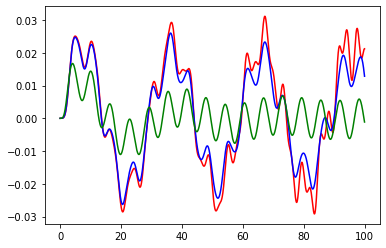

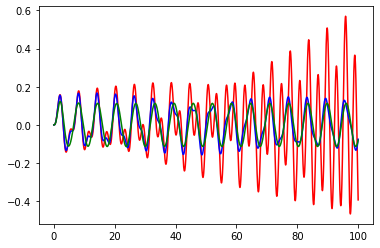

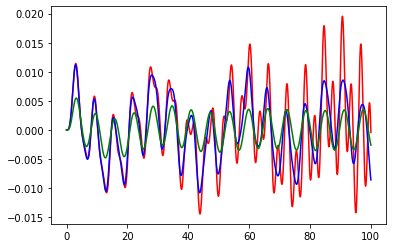

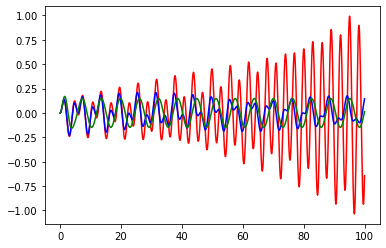

In [48]:
for i in range(2*n):
    plt.figure()
    plt.plot(t, xo[:,i], 'r', t, x[:,i,0],'b', t, x[:,i,Zmax-2],'g')
del i 
    

[[-0.06644686  0.03940376  0.0117174  -0.001055  ]
 [ 0.03940376 -0.82799294 -0.02199406 -0.00562895]
 [ 0.01168963 -0.02197799 -0.01301747  0.00132396]
 [-0.00083283 -0.00575751  0.06509745 -0.0231558 ]]
(50, 3)
None


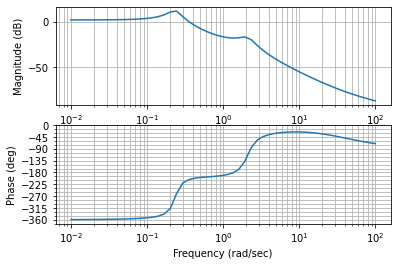

In [50]:
del mag_pc, phase_pc, om_pc
Kpr = np.load('ControlPRL_QC.npy')
print(Kpr)
Cd1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
mag_pc, phase_pc, om_pc = bode(ss(A-Kpr, E, Cd1[0, :]-Kpr[0, :], np.array([0]).T), logspace(-2, 2), plot=True)
input = np.array([om_pc, mag_pc, phase_pc])
print(input.T.shape)
result=np.savetxt('Bode_pra.txt', input.T, delimiter=' ')
print(result)

[[-0.06644686  0.03940376  0.0117174  -0.001055  ]
 [ 0.03940376 -0.82799294 -0.02199406 -0.00562895]
 [ 0.01168963 -0.02197799 -0.01301747  0.00132396]
 [-0.00083283 -0.00575751  0.06509745 -0.0231558 ]]
[[-0.06644686  0.03940376  0.0117174  -0.001055  ]
 [ 0.03940376 -0.82799294 -0.02199406 -0.00562895]
 [ 0.01168963 -0.02197799 -0.01301747  0.00132396]
 [-0.00083283 -0.00575751  0.06509745 -0.0231558 ]]


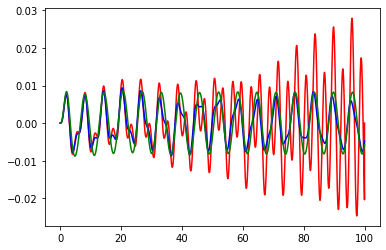

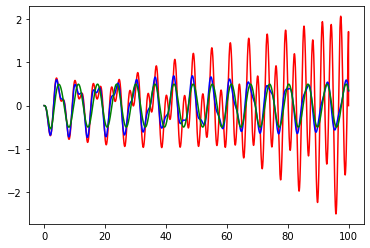

In [51]:
# Figure (Structural responses)
print(BK[0:2*n,0:2*n,Zmax-1])
# Save results
np.save('ControlPRL_QC.npy', BK[0:2*n,0:2*n,Zmax-1])
b = np.load('ControlPRL_QC.npy')
print(b)
Cd1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
yp_z0 = (Cd1-BK[0:2*n,0:2*n,0]) @ np.array([x[:,:,0].T])
yp_zmax = (Cd1-BK[0:2*n,0:2*n,Zmax-1]) @ np.array([x[:,:,Zmax-2].T]) 

for i in range(2,len(Cd1)):
    plt.figure()
    plt.plot(t, yo[:,i-1], 'r', t, yp_z0[:,i,:].T,'b', t, yp_zmax[:,i,:].T,'g') 

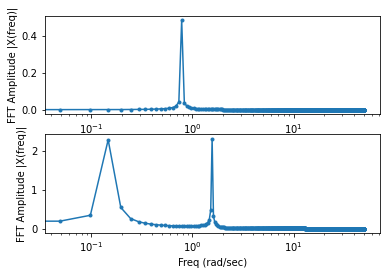

In [79]:
# Testing of trained P controller
# Input Road Profile
amplitude1   = 0.5*(np.sin(0.2*t) + np.sin(2*t))
len(t)
plt.figure()
plt.plot(t, amplitude1)
sr = 1/dt  # sampling frequency
N1 = 2046  # Number of samples
fstep = sr/N1  # freq interval
f = np.linspace(0, (N1-1)*fstep, N1)

# Perform FFT
X = np.fft.fft(amplitude)
X_mag = np.abs(X)/N1

X1 = np.fft.fft(amplitude1)
X1_mag = np.abs(X1)/N1

f_plot = f[0:int(N1/2+1)]
X_mag_plot = 2*X_mag[0:int(N1/2+1)]
X_mag_plot[0] = X_mag_plot[0] / 2 # DC component does not need to multiply by 2

X1_mag_plot = 2*X1_mag[0:int(N1/2+1)]
X1_mag_plot[0] = X1_mag_plot[0] / 2 # DC component does not need to multiply by 2


# Plot 
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
ax1.plot(f_plot, X_mag_plot, '.-')
ax2.plot(f_plot, X1_mag_plot, '.-')
ax2.set_xlabel('Freq (rad/sec)')
ax1.set_ylabel('FFT Amplitude |X(freq)|')
ax2.set_ylabel('FFT Amplitude |X(freq)|')
ax1.semilogx()
ax2.semilogx()
plt.show()

In [80]:
BKt = np.load('ControllerRL_QC.npy')
Kp1 = np.load('ControllerP_QC.npy')
xt = np.zeros([len(t), 2*n])  # State
yt = np.zeros([len(t), len(Cd1)])  # State
print(BKt)
print(Kp1)
for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    h = amplitude1[tkk] 
    xn = np.array([xt[tkk,:]]).T
#   print(xn)
    xn1 = dydx(A, BKt, E, 1, h, xn)
    xt[tkk+1,:] = xn1.T
    yn1 = (Cd1-BKt) @ xn1
    yt[tkk+1,:] = yn1.T

[[-0.06644686  0.03940376  0.0117174  -0.001055  ]
 [ 0.03940376 -0.82799294 -0.02199406 -0.00562895]
 [ 0.01168963 -0.02197799 -0.01301747  0.00132396]
 [-0.00083283 -0.00575751  0.06509745 -0.0231558 ]]
[[  0.49590136  -1.14546156  35.69758159 -11.83173935]]


In [81]:
# Open loop and optimal control
sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
t_c,yuct,xuct = signal.lsim(sys_uc,amplitude1,t)
t_c,yot,xot = signal.lsim(sys_c,amplitude1,t)

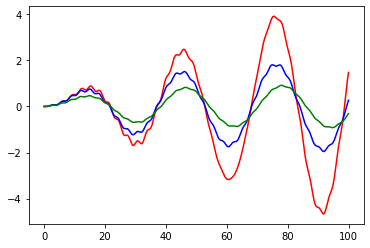

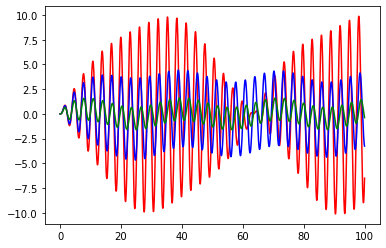

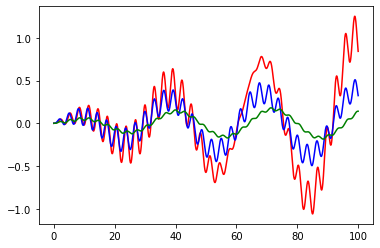

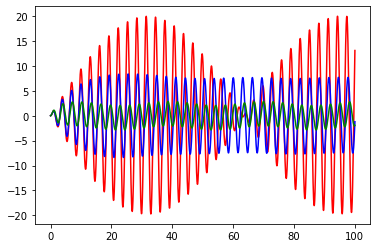

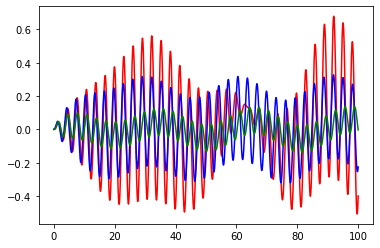

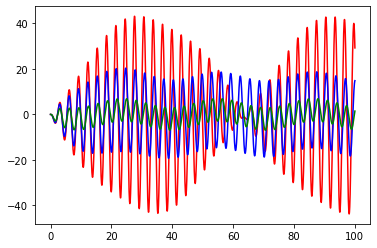

In [84]:
for i in range(2*n):
    plt.figure()
    plt.plot(t, xuct[:,i], 'r', t,xot[:,i],'b', t, xt[:,i],'g')
del i 
for i in range(1,len(Cd)):
    plt.figure()
    plt.plot(t, yuct[:,i], 'r', t, yot[:,i],'b', t, yt[:,i+1],'g')

(10001, 3)
None
(10001, 2)
None


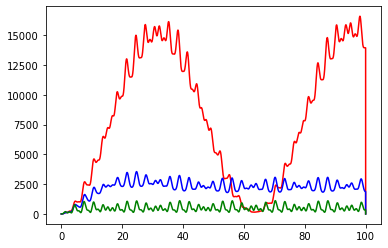

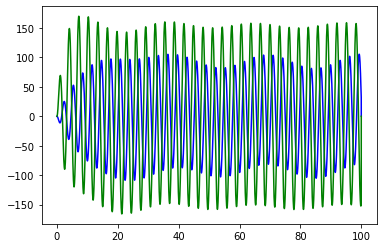

In [102]:
Euct = np.zeros([len(t), r]) 
Eot = np.zeros([len(t), r])  
Et = np.zeros([len(t), r]) 
Fot = np.zeros([len(t), r])  
Ft = np.zeros([len(t), r]) 
for i in range(0,len(t)-1):
    En0 = 0.5*((xuct[i,:] @ Qp)@ (xuct[i,:].T))
    Euct[i,:] = En0
    En1 = 0.5*((xot[i,:] @ Qp)@ (xot[i,:].T))
    Eot[i,:] = En1
    En2 = ((xt[i,:] @ Qp)@ (xt[i,:].T))
    Et[i,:] = En2
    Fn1 = Kp1 @ (xot[i,:].T)
    Fot[i,:] = Fn1
    Fn2 = Kpt @ (xt[i,:].T)
    Ft[i,:] = Fn2
#     En2 = 0.5*((xt[i,:] @ Qp)@ (xt[i,:].T))
#     Et[i,:] = En2
plt.figure()
plt.plot(t, Euct,'r', t, Eot,'b', t, Et,'g')
plt.figure()
plt.plot(t, Fot, 'b', t, Ft, 'g')